In [1]:
import pandas as pd
import os

def load_datasets(base_path='e:\\SEMESTER 5\\DEEP LEARNING\\FINAL\\neurips-open-polymer-prediction-2025'):
    """
    Load all datasets from the project directory.
    
    Parameters:
    -----------
    base_path : str
        Base path to the project directory
        
    Returns:
    --------
    dict : Dictionary containing all loaded datasets
    """
    datasets = {}
    
    # Load main train dataset
    train_path = os.path.join(base_path, 'train.csv')
    datasets['train'] = pd.read_csv(train_path)
    # Load main test dataset
    test_path = os.path.join(base_path, 'test.csv')
    datasets['test'] = pd.read_csv(test_path)
    
    # Load supplementary datasets
    supplement_path = os.path.join(base_path, 'train_supplement')
    for i in range(1, 5):
        dataset_path = os.path.join(supplement_path, f'dataset{i}.csv')
        datasets[f'dataset{i}'] = pd.read_csv(dataset_path)
    
    return datasets


data = load_datasets()
test_df = data['test']
train_df = data['train']
dataset1_df = data['dataset1']
dataset2_df = data['dataset2']
dataset3_df = data['dataset3']
dataset4_df = data['dataset4']

In [2]:
from rdkit import Chem 
from rdkit.Chem import AllChem 
from rdkit.Chem.rdmolops import RemoveHs

def safe_mol_from_smiles(smiles):
    if pd.isna(smiles) or not isinstance(smiles, str) or smiles.strip() == '':
        return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except:
        return None
    
def largest_fragment(mol):
    frags = Chem.GetMolFrags(mol, asMols=True)
    if len(frags) == 1:
        return mol
    largest = max(frags, key=lambda m: m.GetNumAtoms())
    return largest

def neutralize_molecule(mol):
    try:
        # RDKit built-in neutralization
        uncharger = Chem.rdMolStandardize.Uncharger()
        mol = uncharger.uncharge(mol)
        return mol
    except:
        return mol
    
def canonicalize(mol):
    try:
        return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None
    
    
def sanitize_smiles_pipeline(smiles):
    # Step 1: Safe Mol
    mol = safe_mol_from_smiles(smiles)
    if mol is None:
        return None

    # Step 2: Remove salts
    mol = largest_fragment(mol)

    # Step 3: Neutralize
    mol = neutralize_molecule(mol)

    # Step 4: Re-sanitize
    try:
        Chem.SanitizeMol(mol)
    except:
        return None

    # Step 5: Canonicalize
    return canonicalize(mol)

In [8]:
# Replace your validate_smiles_entries call with this:

def validate_smiles_entries_dict(dfs_dict, smiles_column="SMILES"):
    """
    SMILES validation using explicit dictionary keys.
    """
    results = {}

    for df_name, df in dfs_dict.items():
        df_copy = df.copy()

        canonical_list = []
        errors = []

        for s in df_copy[smiles_column]:
            try:
                mol = Chem.MolFromSmiles(s, sanitize=True)
                if mol is None:
                    canonical_list.append(None)
                    errors.append({"SMILES": s, "error": "MolFromSmiles returned None"})
                else:
                    canon = Chem.MolToSmiles(mol, canonical=True)
                    canonical_list.append(canon)
                    errors.append(None)
            except Exception as e:
                canonical_list.append(None)
                errors.append({"SMILES": s, "error": str(e)})

        df_copy["canonical_SMILES"] = canonical_list
        df_copy["sanitization_error"] = errors

        # Summary QC
        total = len(df_copy)
        valid = df_copy["canonical_SMILES"].notna().sum()
        invalid = total - valid
        unique_raw = df_copy[smiles_column].nunique()
        unique_canon = df_copy["canonical_SMILES"].nunique()

        print("\n=====================================")
        print(f"🔎 QC for {df_name}")
        print("=====================================")
        print(f"Total entries:                  {total}")
        print(f"Valid sanitized molecules:      {valid}")
        print(f"Invalid molecules:              {invalid}")
        print(f"Raw unique SMILES:              {unique_raw}")
        print(f"Canonical unique SMILES:        {unique_canon}")
        print(f"Duplicates lost after cleaning: {unique_raw - unique_canon}")
        print("-------------------------------------")

        invalid_df = df_copy[df_copy["canonical_SMILES"].isna()]
        if len(invalid_df) > 0:
            print("❌ Invalid molecules found:")
            print(invalid_df[[smiles_column, "sanitization_error"]].head())
        else:
            print("✅ No invalid molecules.")

        results[df_name] = {
            "clean_df": df_copy[df_copy["canonical_SMILES"].notna()].copy(),
            "invalid_df": invalid_df.copy(),
            "full_df": df_copy,
        }

    return results

# Use explicit dictionary with names
checklist = {
    'test_df': test_df,
    'train_df': train_df,
    'dataset1_df': dataset1_df,
    'dataset2_df': dataset2_df,
    'dataset3_df': dataset3_df,
    'dataset4_df': dataset4_df
}

qc_results = validate_smiles_entries_dict(checklist)

# Now extract cleaned DataFrames
train_df = qc_results['train_df']['clean_df']
dataset1_df = qc_results['dataset1_df']['clean_df']
dataset2_df = qc_results['dataset2_df']['clean_df']
dataset3_df = qc_results['dataset3_df']['clean_df']
dataset4_df = qc_results['dataset4_df']['clean_df']
test_df = qc_results['test_df']['clean_df']


🔎 QC for test_df
Total entries:                  3
Valid sanitized molecules:      3
Invalid molecules:              0
Raw unique SMILES:              3
Canonical unique SMILES:        3
Duplicates lost after cleaning: 0
-------------------------------------
✅ No invalid molecules.

🔎 QC for train_df
Total entries:                  7973
Valid sanitized molecules:      7973
Invalid molecules:              0
Raw unique SMILES:              7973
Canonical unique SMILES:        7973
Duplicates lost after cleaning: 0
-------------------------------------
✅ No invalid molecules.

🔎 QC for dataset1_df
Total entries:                  874
Valid sanitized molecules:      874
Invalid molecules:              0
Raw unique SMILES:              867
Canonical unique SMILES:        866
Duplicates lost after cleaning: 1
-------------------------------------
✅ No invalid molecules.

🔎 QC for dataset2_df
Total entries:                  7208
Valid sanitized molecules:      7208
Invalid molecules:         

In [41]:
train_df

,id,SMILES,Tg,FFV,Tc,Density,Rg,canonical_SMILES,sanitization_error
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,*CC(*)c1ccccc1C(=O)OCCCCCC,None
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,None
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,None
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,None
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,None
...,...,...,...,...,...,...,...,...,...
7968,2146592435,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,NaN,0.367498,NaN,NaN,NaN,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,None
7969,2146810552,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,NaN,0.353280,NaN,NaN,NaN,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,None
7970,2147191531,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,NaN,0.369411,NaN,NaN,NaN,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,None
7971,2147435020,*C=C(*)c1ccccc1C,261.662355,NaN,NaN,NaN,NaN,*C=C(*)c1ccccc1C,None


In [9]:
dataset_merge = [train_df, dataset1_df, dataset3_df, dataset4_df]
dataset_cluster = [dataset2_df]

def prepare_for_merge(df, key="canonical_SMILES"):
    """
    Remove duplicate SMILES columns and preserve only the key for merging.
    Keeps track of original row count and unique keys.
    """
    df = df.copy()
    
    # Drop raw SMILES if canonical is used for merge
    if "SMILES" in df.columns and key != "SMILES":
        df = df.drop(columns=["SMILES"])

    # Drop duplicate key rows
    before = len(df)
    df = df.drop_duplicates(subset=[key])
    after = len(df)

    print(f"[Prepare] Rows before={before}, after deduplicate={after}")
    return df
from functools import reduce

def robust_merge(datasets, key="canonical_SMILES"):
    """
    Safely merges multiple datasets on canonical SMILES.
    Logs before/after information for traceability.
    """
    # Prepare datasets
    cleaned = [prepare_for_merge(df, key=key) for df in datasets]

    # Log BEFORE merge stats
    print("\n===== BEFORE MERGE STATS =====")
    for i, df in enumerate(cleaned):
        print(f"Dataset {i+1}: rows={len(df)}, unique keys={df[key].nunique()}")

    # Reduce merge
    merged = reduce(
        lambda left, right: left.merge(
            right, on=key, how="outer", suffixes=("", "_dup")
        ),
        cleaned
    )

    # Clean leftover duplicate columns (_dup)
    dup_cols = [c for c in merged.columns if c.endswith("_dup")]
    if dup_cols:
        merged = merged.drop(columns=dup_cols)

    # Log AFTER merge stats
    print("\n===== AFTER MERGE STATS =====")
    print(f"Merged rows={len(merged)}")
    print(f"Merged unique keys={merged[key].nunique()}")

    return merged


def compare_augmentation(base_df, augmented_df, key="canonical_SMILES"):
    """
    Show which molecules the external datasets added.
    """
    base_keys = set(base_df[key])
    aug_keys = set(augmented_df[key])

    added = aug_keys - base_keys
    lost  = base_keys - aug_keys  # should be empty unless outer merge

    print("\n===== AUGMENTATION DIAGNOSTICS =====")
    print(f"New molecules added: {len(added)}")
    print(f"Molecules missing (should be 0): {len(lost)}")

    added_df = augmented_df[augmented_df[key].isin(added)]
    print("Example added rows:")
    print(added_df.head())

    return added_df

df_internal = robust_merge(dataset_merge, key="canonical_SMILES")
df_augmented = robust_merge([df_internal] + dataset_cluster)

augment_inspection = compare_augmentation(df_internal, df_augmented)



[Prepare] Rows before=7973, after deduplicate=7973
[Prepare] Rows before=874, after deduplicate=866
[Prepare] Rows before=46, after deduplicate=46
[Prepare] Rows before=862, after deduplicate=862

===== BEFORE MERGE STATS =====
Dataset 1: rows=7973, unique keys=7973
Dataset 2: rows=866, unique keys=866
Dataset 3: rows=46, unique keys=46
Dataset 4: rows=862, unique keys=862

===== AFTER MERGE STATS =====
Merged rows=8972
Merged unique keys=8972
[Prepare] Rows before=8972, after deduplicate=8972
[Prepare] Rows before=7208, after deduplicate=7174

===== BEFORE MERGE STATS =====
Dataset 1: rows=8972, unique keys=8972
Dataset 2: rows=7174, unique keys=7174

===== AFTER MERGE STATS =====
Merged rows=10343
Merged unique keys=10343

===== AUGMENTATION DIAGNOSTICS =====
New molecules added: 1371
Molecules missing (should be 0): 0
Example added rows:
   id  Tg  FFV  Tc  Density  Rg  \
0 NaN NaN  NaN NaN      NaN NaN   
1 NaN NaN  NaN NaN      NaN NaN   
2 NaN NaN  NaN NaN      NaN NaN   
3 NaN N

In [12]:
df_augmented

,id,Tg,FFV,Tc,Density,Rg,canonical_SMILES,sanitization_error,TC_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(C(C)(C)C)cc1)c1ccccc1,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(CCCC)cc1)c1ccccc1,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(Oc2ccccc2)cc1)c1ccccc1,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C(C)C)(C(C)C)C(C)C)cc1)c1...,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C)(C)C)cc1)c1ccccc1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10338,1.115536e+09,NaN,NaN,0.38800,NaN,NaN,*c1sc(*)c(OCCCCCCCCCCCCCCCC)c1C,None,0.38800
10339,2.731393e+08,NaN,NaN,0.37475,0.904355,14.348260,*c1sc(*)c(OCCCCCCCCCCCCCCCCCCCC)c1C,None,0.37475
10340,4.633390e+08,NaN,NaN,0.44475,0.968872,15.087862,*c1sc(*)c2c1OCC(CCCCCCCCCCCCCCCC)O2,None,0.44475
10341,NaN,NaN,NaN,NaN,NaN,NaN,*c1sc(*)c2sc(CCCCCCCCC)nc12,NaN,0.48200


In [14]:
df_augmented = df_augmented.drop(columns=["sanitization_error","id"])
df_augmented

,Tg,FFV,Tc,Density,Rg,canonical_SMILES,TC_mean
0,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(C(C)(C)C)cc1)c1ccccc1,NaN
1,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(CCCC)cc1)c1ccccc1,NaN
2,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(Oc2ccccc2)cc1)c1ccccc1,NaN
3,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C(C)C)(C(C)C)C(C)C)cc1)c1...,NaN
4,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C)(C)C)cc1)c1ccccc1,NaN
...,...,...,...,...,...,...,...
10338,NaN,NaN,0.38800,NaN,NaN,*c1sc(*)c(OCCCCCCCCCCCCCCCC)c1C,0.38800
10339,NaN,NaN,0.37475,0.904355,14.348260,*c1sc(*)c(OCCCCCCCCCCCCCCCCCCCC)c1C,0.37475
10340,NaN,NaN,0.44475,0.968872,15.087862,*c1sc(*)c2c1OCC(CCCCCCCCCCCCCCCC)O2,0.44475
10341,NaN,NaN,NaN,NaN,NaN,*c1sc(*)c2sc(CCCCCCCCC)nc12,0.48200


In [24]:
import os

save_dir = "../data"  # relative dari src/
save_path = os.path.join(save_dir, "augmented_training_data.csv")

df_augmented.to_csv(save_path, index=False)


In [26]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import torch
from torch_geometric.data import Data
import numpy as np

def get_atom_features(atom):
    """
    Extract node features from RDKit atom object.
    Features: atomic number, valence, degree, formal charge, aromaticity
    """
    features = [
        atom.GetAtomicNum(),                    # Atomic number
        atom.GetTotalValence(),                 # Valence
        atom.GetDegree(),                       # Degree
        atom.GetFormalCharge(),                 # Formal charge
        int(atom.GetIsAromatic())               # Aromaticity (0 or 1)
    ]
    return features

def get_bond_features(bond):
    """
    Extract edge features from RDKit bond object.
    Features: bond type, conjugation, aromatic flags
    """
    bond_type_map = {
        Chem.BondType.SINGLE: 1,
        Chem.BondType.DOUBLE: 2,
        Chem.BondType.TRIPLE: 3,
        Chem.BondType.AROMATIC: 4
    }
    
    features = [
        bond_type_map.get(bond.GetBondType(), 0),  # Bond type
        int(bond.GetIsConjugated()),                # Conjugation
        int(bond.GetIsAromatic())                   # Aromatic flag
    ]
    return features

def smiles_to_graph(smiles):
    """
    Convert SMILES string to PyTorch Geometric Data object.
    
    Returns:
    --------
    Data object with:
        - x: node feature matrix [num_nodes, 5]
        - edge_index: edge connectivity [2, num_edges]
        - edge_attr: edge features [num_edges, 3]
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # Edge indices and features
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Add both directions (undirected graph)
        edge_indices.append([i, j])
        edge_indices.append([j, i])
        
        bond_feat = get_bond_features(bond)
        edge_features.append(bond_feat)
        edge_features.append(bond_feat)
    
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

d:\anaconda\envs\dl_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [42]:
df_augmented

,Tg,FFV,Tc,Density,Rg,canonical_SMILES,TC_mean
0,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(C(C)(C)C)cc1)c1ccccc1,NaN
1,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(CCCC)cc1)c1ccccc1,NaN
2,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(Oc2ccccc2)cc1)c1ccccc1,NaN
3,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C(C)C)(C(C)C)C(C)C)cc1)c1...,NaN
4,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C)(C)C)cc1)c1ccccc1,NaN
...,...,...,...,...,...,...,...
10338,NaN,NaN,0.38800,NaN,NaN,*c1sc(*)c(OCCCCCCCCCCCCCCCC)c1C,0.38800
10339,NaN,NaN,0.37475,0.904355,14.348260,*c1sc(*)c(OCCCCCCCCCCCCCCCCCCCC)c1C,0.37475
10340,NaN,NaN,0.44475,0.968872,15.087862,*c1sc(*)c2c1OCC(CCCCCCCCCCCCCCCC)O2,0.44475
10341,NaN,NaN,NaN,NaN,NaN,*c1sc(*)c2sc(CCCCCCCCC)nc12,0.48200


In [ ]:
import torch
from torch_geometric.data import Dataset, DataLoader, Batch
import pandas as pd

class PolymerDataset(Dataset):
    """
    Custom dataset for polymer property prediction.
    """
    def __init__(self, df, target_columns=['Tg', 'FFV', 'Tc', 'Density', 'Rg']):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.target_columns = target_columns
        self.smiles_column = 'canonical_SMILES'
        
        # Filter out rows with all NaN targets
        valid_rows = self.df[target_columns].notna().any(axis=1)
        self.df = self.df[valid_rows].reset_index(drop=True)
        
    def len(self):
        return len(self.df)
    
    def get(self, idx):
        row = self.df.iloc[idx]
        smiles = row[self.smiles_column]
        
        # Convert SMILES to graph
        graph = smiles_to_graph(smiles)
        if graph is None:
            return None
        
        # Extract target values (handle NaN)
        targets = []
        target_mask = []
        for col in self.target_columns:
            val = row[col]
            if pd.isna(val):
                targets.append(0.0)
                target_mask.append(0)
            else:
                targets.append(float(val))
                target_mask.append(1)
        
        graph.y = torch.tensor([targets], dtype=torch.float)  # ← FIX: Add extra dimension
        graph.y_mask = torch.tensor([target_mask], dtype=torch.float)  # ← FIX: Add extra dimension
        
        return graph

def custom_collate(batch):
    """
    Custom collate function to handle None values and properly batch graphs.
    """
    # Filter out None values
    batch = [item for item in batch if item is not None]
    
    if len(batch) == 0:
        return None
    
    # Use PyTorch Geometric's Batch.from_data_list
    return Batch.from_data_list(batch)

def create_dataloaders(df, batch_size=32, train_split=0.8):
    """
    Create train and validation dataloaders.
    """
    dataset = PolymerDataset(df)
    
    # Train/val split
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    # Use custom collate function
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=custom_collate,  # ← ADD THIS
        num_workers = 4,
        pin_memory = True,
        persistent_workers = True,
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=custom_collate,  # ← ADD THIS
        num_workers = 4,
        pin_memory = True,
        persistent_workers = True
    )
    
    return train_loader, val_loader

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool

class PolymerGNN(nn.Module):
    """
    3-layer Graph Convolutional Network for polymer property prediction.
    """
    def __init__(self, num_node_features=5, num_outputs=5, hidden_dim=64, embedding_dim=32):
        super(PolymerGNN, self).__init__()
        
        # Graph convolution layers
        self.conv1 = GraphConv(num_node_features, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, embedding_dim)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        
        # Dense layers for property prediction
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.fc2 = nn.Linear(64, num_outputs)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GCN layers with ReLU and batch norm
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Global mean pooling (32-dim embeddings)
        embeddings = global_mean_pool(x, batch)
        
        # Dense layers for final predictions
        x = F.relu(self.fc1(embeddings))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def get_embeddings(self, data):
        """Extract 32-dim molecular embeddings."""
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        
        return global_mean_pool(x, batch)

In [35]:
def extract_embeddings_for_xgboost(model, dataloader, device):
    """
    Extract 32D embeddings from GNN for all molecules.
    """
    model.eval()
    embeddings = []
    targets = []
    masks = []
    
    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue
            batch = batch.to(device)
            
            # Use get_embeddings() method
            emb = model.get_embeddings(batch)  # Shape: [batch_size, 32]
            
            embeddings.append(emb.cpu().numpy())
            targets.append(batch.y.cpu().numpy())
            masks.append(batch.y_mask.cpu().numpy())
    
    embeddings = np.vstack(embeddings)  # [num_samples, 32]
    targets = np.vstack(targets)        # [num_samples, 5]
    masks = np.vstack(masks)            # [num_samples, 5]
    
    return embeddings, targets, masks

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# ---------------------------------------------------------
# Masked MSE Loss
# ---------------------------------------------------------
def masked_mse_loss(pred, target, mask):
    """
    Compute MSE only over available target values.
    pred, target, mask = [batch, 5]
    """
    # Sanity reshape if dataloader flattens targets
    if target.dim() == 1:
        target = target.view(pred.shape[0], -1)
        mask   = mask.view(pred.shape[0], -1)

    loss = (pred - target) ** 2
    loss = loss * mask
    return loss.sum() / mask.sum().clamp(min=1)


# ---------------------------------------------------------
# Training loop for one epoch
# ---------------------------------------------------------
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, desc="Training"):
        if batch is None:
            continue

        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(batch)
        loss = masked_mse_loss(pred, batch.y, batch.y_mask)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / max(len(loader), 1)


# ---------------------------------------------------------
# Validation loop
# ---------------------------------------------------------
def validate(model, loader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue

            batch = batch.to(device)
            pred = model(batch)
            loss = masked_mse_loss(pred, batch.y, batch.y_mask)
            total_loss += loss.item()

    return total_loss / max(len(loader), 1)


# ---------------------------------------------------------
# Full Training Procedure
# ---------------------------------------------------------
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    lr=1e-3,
    device=None
):
    # Resolve device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\n🚀 Using device: {device}")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=10,
        factor=0.5
    )

    best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss   = validate(model, val_loader, device)

        scheduler.step(val_loss)

        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            print("💾 Saved new best model!")

    print("\n🎉 Training complete! Best Val Loss:", best_val_loss)
    return model


In [39]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Train GNN to learn embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PolymerGNN(num_node_features=5, num_outputs=5).to(device)

# Create dataloaders
train_loader, val_loader = create_dataloaders(df_augmented, batch_size=32, train_split=0.8)

# Train GNN
train_model(model, train_loader, val_loader, num_epochs=50, device=device)

# Step 2: Extract embeddings
print("\n🔄 Extracting embeddings for XGBoost...")
train_emb, train_y, train_mask = extract_embeddings_for_xgboost(model, train_loader, device)
val_emb, val_y, val_mask = extract_embeddings_for_xgboost(model, val_loader, device)

print(f"Train embeddings shape: {train_emb.shape}")  # Should be [N_train, 32]
print(f"Val embeddings shape: {val_emb.shape}")      # Should be [N_val, 32]

# Step 3: Train XGBoost on embeddings
print("\n🌳 Training XGBoost on GNN embeddings...")

# Define XGBoost base regressor
base_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Multi-output wrapper
xgb_model = MultiOutputRegressor(base_xgb)

# Train on embeddings
xgb_model.fit(train_emb, train_y)

# Step 4: Evaluate
val_pred = xgb_model.predict(val_emb)

# Calculate metrics per property
property_names = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
print("\n📊 XGBoost Performance:")
print("=" * 50)

for i, prop in enumerate(property_names):
    # Only evaluate where target is available
    mask_idx = val_mask[:, i] == 1
    
    if mask_idx.sum() > 0:
        y_true = val_y[mask_idx, i]
        y_pred = val_pred[mask_idx, i]
        
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print(f"{prop:10s} | MSE: {mse:.4f} | R²: {r2:.4f} | N: {mask_idx.sum()}")
    else:
        print(f"{prop:10s} | No validation samples")

C:\Users\Loq Gaming\AppData\Local\Temp\ipykernel_29408\7337724.py:76: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(
C:\Users\Loq Gaming\AppData\Local\Temp\ipykernel_29408\7337724.py:82: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(



🚀 Using device: cuda


Training: 100%|██████████| 200/200 [00:07<00:00, 26.26it/s]



Epoch 1/50
Train Loss: 1071.019105 | Val Loss: 993.503101
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 29.23it/s]



Epoch 2/50
Train Loss: 663.650427 | Val Loss: 441.504191
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 30.67it/s]



Epoch 3/50
Train Loss: 404.355163 | Val Loss: 317.145170
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 30.65it/s]



Epoch 4/50
Train Loss: 347.468621 | Val Loss: 330.896447


Training: 100%|██████████| 200/200 [00:06<00:00, 28.69it/s]



Epoch 5/50
Train Loss: 343.920606 | Val Loss: 303.536935
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:07<00:00, 26.03it/s]



Epoch 6/50
Train Loss: 329.900796 | Val Loss: 287.730844
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 28.85it/s]



Epoch 7/50
Train Loss: 325.089214 | Val Loss: 283.863946
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 31.58it/s]



Epoch 8/50
Train Loss: 306.252276 | Val Loss: 289.286998


Training: 100%|██████████| 200/200 [00:06<00:00, 31.75it/s]



Epoch 9/50
Train Loss: 289.452673 | Val Loss: 317.312888


Training: 100%|██████████| 200/200 [00:06<00:00, 30.54it/s]



Epoch 10/50
Train Loss: 305.005195 | Val Loss: 294.690692


Training: 100%|██████████| 200/200 [00:06<00:00, 29.78it/s]



Epoch 11/50
Train Loss: 304.960788 | Val Loss: 306.642377


Training: 100%|██████████| 200/200 [00:06<00:00, 30.79it/s]



Epoch 12/50
Train Loss: 317.246921 | Val Loss: 328.035225


Training: 100%|██████████| 200/200 [00:06<00:00, 30.90it/s]



Epoch 13/50
Train Loss: 320.801624 | Val Loss: 278.460568
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 30.74it/s]



Epoch 14/50
Train Loss: 328.887946 | Val Loss: 279.214600


Training: 100%|██████████| 200/200 [00:06<00:00, 31.76it/s]



Epoch 15/50
Train Loss: 292.656125 | Val Loss: 279.723425


Training: 100%|██████████| 200/200 [00:06<00:00, 30.75it/s]



Epoch 16/50
Train Loss: 300.090865 | Val Loss: 272.209184
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 30.89it/s]



Epoch 17/50
Train Loss: 293.726198 | Val Loss: 271.294176
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 29.03it/s]



Epoch 18/50
Train Loss: 293.361746 | Val Loss: 285.038333


Training: 100%|██████████| 200/200 [00:06<00:00, 30.44it/s]



Epoch 19/50
Train Loss: 290.069676 | Val Loss: 306.833274


Training: 100%|██████████| 200/200 [00:06<00:00, 30.07it/s]



Epoch 20/50
Train Loss: 293.990427 | Val Loss: 307.627958


Training: 100%|██████████| 200/200 [00:06<00:00, 30.64it/s]



Epoch 21/50
Train Loss: 282.690460 | Val Loss: 279.808609


Training: 100%|██████████| 200/200 [00:06<00:00, 30.92it/s]



Epoch 22/50
Train Loss: 288.034689 | Val Loss: 256.866825
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:07<00:00, 28.11it/s]



Epoch 23/50
Train Loss: 279.642567 | Val Loss: 250.421251
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:06<00:00, 29.93it/s]



Epoch 24/50
Train Loss: 289.183990 | Val Loss: 264.243871


Training: 100%|██████████| 200/200 [00:06<00:00, 29.51it/s]



Epoch 25/50
Train Loss: 284.518015 | Val Loss: 263.877663


Training: 100%|██████████| 200/200 [00:06<00:00, 30.34it/s]



Epoch 26/50
Train Loss: 297.446673 | Val Loss: 289.892919


Training: 100%|██████████| 200/200 [00:06<00:00, 28.95it/s]



Epoch 27/50
Train Loss: 271.881968 | Val Loss: 287.355705


Training: 100%|██████████| 200/200 [00:07<00:00, 28.24it/s]



Epoch 28/50
Train Loss: 297.882297 | Val Loss: 279.247719


Training: 100%|██████████| 200/200 [00:07<00:00, 25.92it/s]



Epoch 29/50
Train Loss: 278.004909 | Val Loss: 292.611736


Training: 100%|██████████| 200/200 [00:07<00:00, 26.85it/s]



Epoch 30/50
Train Loss: 266.370298 | Val Loss: 311.222253


Training: 100%|██████████| 200/200 [00:07<00:00, 28.28it/s]



Epoch 31/50
Train Loss: 257.186806 | Val Loss: 298.963695


Training: 100%|██████████| 200/200 [00:07<00:00, 27.41it/s]



Epoch 32/50
Train Loss: 263.591896 | Val Loss: 280.733106


Training: 100%|██████████| 200/200 [00:07<00:00, 28.19it/s]



Epoch 33/50
Train Loss: 271.441419 | Val Loss: 281.945735


Training: 100%|██████████| 200/200 [00:07<00:00, 26.53it/s]



Epoch 34/50
Train Loss: 265.354652 | Val Loss: 280.516004


Training: 100%|██████████| 200/200 [00:07<00:00, 28.21it/s]



Epoch 35/50
Train Loss: 268.941119 | Val Loss: 269.066056


Training: 100%|██████████| 200/200 [00:07<00:00, 26.58it/s]



Epoch 36/50
Train Loss: 251.954148 | Val Loss: 262.960837


Training: 100%|██████████| 200/200 [00:06<00:00, 28.77it/s]



Epoch 37/50
Train Loss: 251.858172 | Val Loss: 259.994795


Training: 100%|██████████| 200/200 [00:07<00:00, 28.57it/s]



Epoch 38/50
Train Loss: 252.635093 | Val Loss: 254.426483


Training: 100%|██████████| 200/200 [00:08<00:00, 24.50it/s]



Epoch 39/50
Train Loss: 247.484569 | Val Loss: 243.459277
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:08<00:00, 24.53it/s]



Epoch 40/50
Train Loss: 267.468362 | Val Loss: 255.070768


Training: 100%|██████████| 200/200 [00:07<00:00, 27.31it/s]



Epoch 41/50
Train Loss: 237.164508 | Val Loss: 248.771160


Training: 100%|██████████| 200/200 [00:06<00:00, 29.37it/s]



Epoch 42/50
Train Loss: 249.152278 | Val Loss: 252.253719


Training: 100%|██████████| 200/200 [00:07<00:00, 27.98it/s]



Epoch 43/50
Train Loss: 238.217644 | Val Loss: 246.093172


Training: 100%|██████████| 200/200 [00:06<00:00, 29.57it/s]



Epoch 44/50
Train Loss: 248.728244 | Val Loss: 258.745639


Training: 100%|██████████| 200/200 [00:07<00:00, 28.42it/s]



Epoch 45/50
Train Loss: 243.265822 | Val Loss: 251.165387


Training: 100%|██████████| 200/200 [00:06<00:00, 29.10it/s]



Epoch 46/50
Train Loss: 258.169455 | Val Loss: 247.542090


Training: 100%|██████████| 200/200 [00:06<00:00, 31.12it/s]



Epoch 47/50
Train Loss: 233.543617 | Val Loss: 249.159398


Training: 100%|██████████| 200/200 [00:06<00:00, 31.89it/s]



Epoch 48/50
Train Loss: 253.101172 | Val Loss: 251.341029


Training: 100%|██████████| 200/200 [00:06<00:00, 31.76it/s]



Epoch 49/50
Train Loss: 258.146917 | Val Loss: 251.401560


Training: 100%|██████████| 200/200 [00:06<00:00, 31.50it/s]



Epoch 50/50
Train Loss: 265.087431 | Val Loss: 259.468341

🎉 Training complete! Best Val Loss: 243.45927712291478

🔄 Extracting embeddings for XGBoost...
Train embeddings shape: (6378, 32)
Val embeddings shape: (1595, 32)

🌳 Training XGBoost on GNN embeddings...

📊 XGBoost Performance:
Tg         | MSE: 18496.7598 | R²: -0.3860 | N: 100
FFV        | MSE: 0.0040 | R²: -3.4952 | N: 1426
Tc         | MSE: 0.0275 | R²: -2.4786 | N: 149
Density    | MSE: 0.5772 | R²: -33.4393 | N: 121
Rg         | MSE: 155.1479 | R²: -7.7558 | N: 120


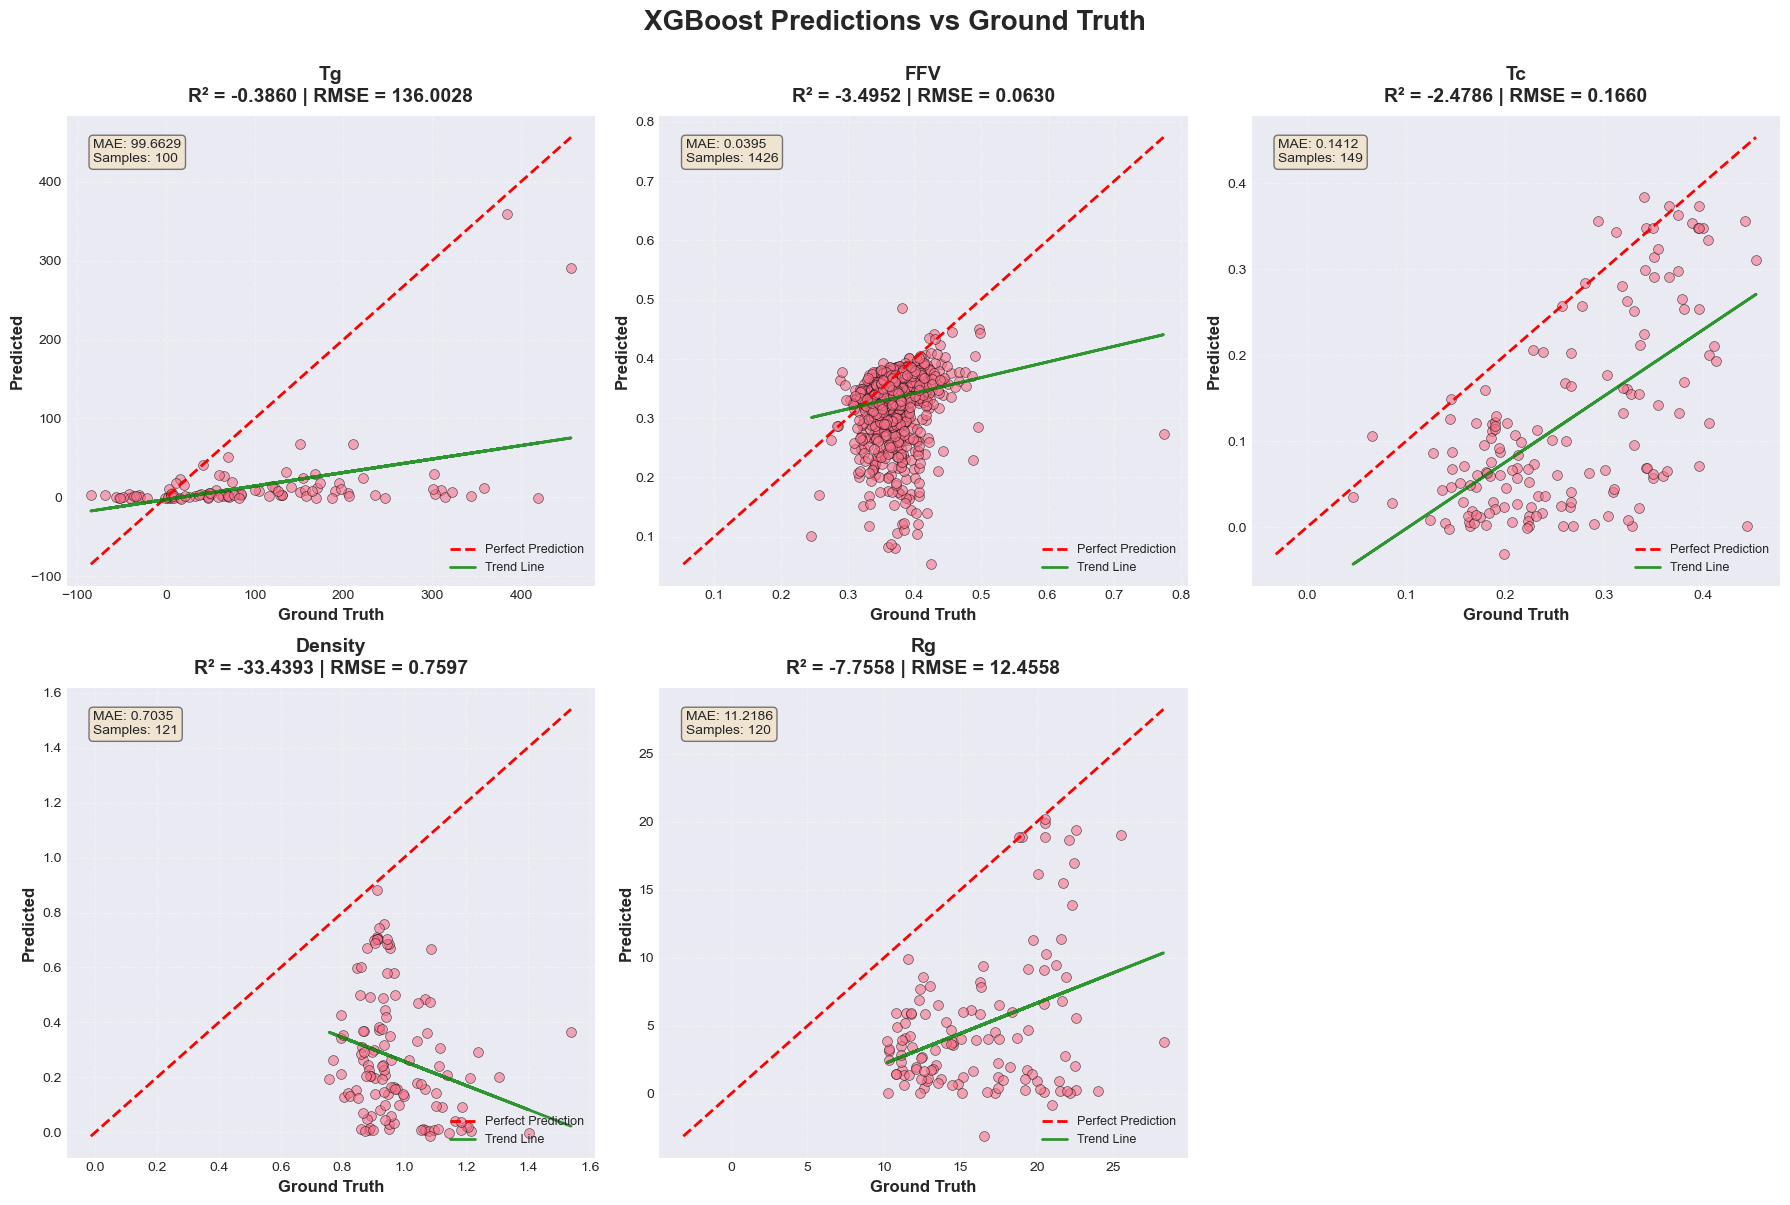


✅ Visualization saved as 'xgboost_predictions_vs_ground_truth.png'


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Property names
property_names = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('XGBoost Predictions vs Ground Truth', fontsize=20, fontweight='bold', y=1.00)

# Flatten axes for easier iteration
axes = axes.flatten()

for i, prop in enumerate(property_names):
    ax = axes[i]
    
    # Get mask for available targets
    mask_idx = val_mask[:, i] == 1
    
    if mask_idx.sum() > 0:
        y_true = val_y[mask_idx, i]
        y_pred = val_pred[mask_idx, i]
        
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        # Scatter plot
        ax.scatter(y_true, y_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        # Add trend line
        z = np.polyfit(y_true, y_pred, 1)
        p = np.poly1d(z)
        ax.plot(y_true, p(y_true), "g-", alpha=0.8, lw=2, label=f'Trend Line')
        
        # Labels and title
        ax.set_xlabel('Ground Truth', fontsize=12, fontweight='bold')
        ax.set_ylabel('Predicted', fontsize=12, fontweight='bold')
        ax.set_title(f'{prop}\nR² = {r2:.4f} | RMSE = {rmse:.4f}', 
                     fontsize=14, fontweight='bold', pad=10)
        
        # Add metrics text box
        textstr = f'MAE: {mae:.4f}\nSamples: {mask_idx.sum()}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        # Grid
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='lower right', fontsize=9)
        
    else:
        ax.text(0.5, 0.5, 'No validation samples', 
                ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.set_title(f'{prop}\nNo Data', fontsize=14, fontweight='bold')

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig('xgboost_predictions_vs_ground_truth.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'xgboost_predictions_vs_ground_truth.png'")